# Trending Seattle Venues and Near AirBnB Data Analysis

  |Author|Date|
  |------|----|
  |_Wilton Beltré_|_September 2019_|
  |      |    |
  

   


<br/>

> Technical explanation for the observation of the most popular venues in the 
> city of Seattle as well as the relationship it has with the vibes of the 
> AirBnB near of their.

<br/>
<br/>

**Content**

[1. Importing Libraries](#1)

[1.1 Getting Seattle Neighborhoods](#1-1)

[1.2 - Seattle Neighborhoods Map](#1-2)

[2 - AirBnB Seattle Data](#2)

[2.1 - Heavy work starts here](#2-1)

[3 - Statistical information of the AirBnB near the venues](#3)

[4 - Showing on Map the trendings venues of Seattle and their connection with near AirBnB](#4)

[5 - Preparing data that to be clusterized](#5)

[5.1 Cluster Neighborhoods](#5-1)

[5.2 Map Clustered](#5-2)


<br/>
<br/>

### <a id="1">1 - Importing Libraries</a>

**The first thing to do is import all required libraries**

In [127]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

# !conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

# measure distance between points (latitude, longitude) in this case
from geopy import distance

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library
from folium import plugins

# Import json packages to explode json columns like related_same_day_brand
import json
from pandas.io.json import json_normalize

# libraries for handle http request/response and data wrangling
import requests
from bs4 import BeautifulSoup
import pandas as pd

print('Libraries imported.')

Libraries imported.


### <a id="1-1">1.1 - Getting Seattle Neighborhoods</a>
**Then, I have been requesting wikipedia html page with all neighborhood and borough from Seattle**

In [125]:
wikilink = "https://en.wikipedia.org/wiki/List_of_neighborhoods_in_Seattle"
res = requests.get(wikilink)

**Reading and parsing html content, next read and convert to a Pandas DataFrame**

In [114]:
soup  = BeautifulSoup(res.content, "lxml") # read/parse html-content
wikitable = soup.find_all("table")[0] # get first html-table
seattle_df = pd.read_html(str(wikitable))[0] # read/convert to pandas dataframe

**Wrangling data: clean NaN content, selecting necessary columns, change names and delete NaN Borough's**

In [115]:
seattle_df = seattle_df[seattle_df['Neighborhood name'].isna() == False]
seattle_df = seattle_df[['Neighborhood name', 'Within larger district']]
seattle_df.columns = ['Neighborhood', 'Borough']
seattle_df = seattle_df[['Borough', 'Neighborhood']]
seattle_df['Borough'].dropna(inplace=True)

# dataframe before content cleaning whit regular expression.
seattle_df.head()

,Borough,Neighborhood
0,Seattle,North Seattle
1,North Seattle[42],Broadview
2,North Seattle[42],Bitter Lake
3,North Seattle[42],North Beach / Blue Ridge
4,North Seattle[42],Crown Hill


**Cleaning and spliting data with Python regular expression**

In [116]:
import re

seattle_df['Borough'] = seattle_df['Borough'].apply(lambda x: re.sub(r'\[.+\]', '', x))
seattle_df['Borough'] = seattle_df['Borough'].apply(lambda x: re.sub(r'\/.+', '', x))
seattle_df['Neighborhood'] = seattle_df['Neighborhood'].apply(lambda x: re.sub(r'\[.+\]', '', x))
seattle_df['Neighborhood'] = seattle_df['Neighborhood'].apply(lambda x: re.sub(r'\(.+\)', '', x))
seattle_df['Neighborhood'] = seattle_df['Neighborhood'].apply(lambda x: re.sub(r'\/.+', '', x))

# dataframe after content cleaning
seattle_df.head()

,Borough,Neighborhood
0,Seattle,North Seattle
1,North Seattle,Broadview
2,North Seattle,Bitter Lake
3,North Seattle,North Beach
4,North Seattle,Crown Hill


**Due to Wikipedia Seattle page don't have coordinates, then I need to implement a mechanism for obtain these.**

**A loop for iterate each Neighborhood and looking for the coordinates with geopy librarie support.**

In [106]:

def find(name):
    address = '{}, Seattle'.format(name['Neighborhood'])
    try:
        geolocator = Nominatim(user_agent="seattle_explorer")
        location = geolocator.geocode(address)
        latitude = location.latitude
        longitude = location.longitude
    except Exception as ex:
        latitude = 0
        longitude = 0
        
    name['Latitude'] = latitude
    name['Longitude'] = longitude
    
    return name

seattle_df = seattle_df.apply(find, axis=1)

seattle_df.head()


,Borough,Neighborhood,latitude,longitude
0,Seattle,North Seattle,47.660773,-122.291497
1,North Seattle,Broadview,47.722320,-122.360407
2,North Seattle,Bitter Lake,47.726236,-122.348764
3,North Seattle,North Beach,47.696210,-122.392362
4,North Seattle,Crown Hill,47.694715,-122.371459


**For convenience, first time I saved the previous result of the DataFrame of Seattle with coordinates**

In [118]:

# seattle_df = seattle_df[seattle_df['Latitude'] > 0]
# seattle_df = seattle_df['Borough','Latitude','Longitude','Neighborhood']
# seattle_df.to_csv('seattle_df.csv')
seattle_df = pd.read_csv('seattle_df.csv')
seattle_df.drop('Unnamed: 0', axis=1, inplace=True)
# seattle_df.to_csv('seattle_df.csv')
seattle_df.head()

,Borough,Neighborhood,Latitude,Longitude
0,Seattle,North Seattle,47.660773,-122.291497
1,North Seattle,Broadview,47.722320,-122.360407
2,North Seattle,Bitter Lake,47.726236,-122.348764
3,North Seattle,North Beach,47.696210,-122.392362
4,North Seattle,Crown Hill,47.694715,-122.371459


**Henceforth Seattle DataFrame with coordinates is called neighborhoods**

In [119]:
neighborhoods = seattle_df

In [120]:
# How many boroughs and neighborhoods I have?
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

The dataframe has 31 boroughs and 121 neighborhoods.


### <a id="1-2">1.2 - Seattle Neighborhoods Map</a>

**Well again geopy is helping to localize the coordinates of Seattle.**

**We'll see now the Map of Seattle with theirs Neighborhoods**

In [121]:
address = 'Seattle, Seattle'

geolocator = Nominatim(user_agent="seattle_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Seattle are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Seattle are 47.6028956, -122.3398408.


In [123]:
%%time

# This is our Map of Seattle with theirs Neighborhoods

map_seattle = folium.Map(location=[latitude, longitude], zoom_start=10.5)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='#853ab0',
        fill=True,
        fill_color='#853ab0',
        fill_opacity=0.7,
        parse_html=False).add_to(map_seattle)  
    
map_seattle

CPU times: user 60 ms, sys: 0 ns, total: 60 ms
Wall time: 61.6 ms


In [11]:
# CLIENT_ID = 'U54SVMROBPRP3B0NW1FF5QPCCEPMKZS0PHHUDNUTQ3KBNFX2' # your Foursquare ID
# CLIENT_SECRET = 'Y5302JRTVUIGCWR1EROFFHUIGFFFAD50N2AZ4J4ND3JN1TSK' # your Foursquare Secret
# VERSION = '20180605' # Foursquare API version

# AR-data-science auths
CLIENT_ID = 'RU3Y3XCL1D3X4IFWHEPI3VYYAEEGSWMVQTWP2PHZ1DEL1E2R' # your Foursquare ID
CLIENT_SECRET = 'GMMPCVSMWDJDXSOTEO22G3FN4H2BUFSZO05SYEGRGW4N5AKL' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version


print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

# type your answer here
LIMIT = 100
radius = 500
section = 'trending'


Your credentails:
CLIENT_ID: RU3Y3XCL1D3X4IFWHEPI3VYYAEEGSWMVQTWP2PHZ1DEL1E2R
CLIENT_SECRET:GMMPCVSMWDJDXSOTEO22G3FN4H2BUFSZO05SYEGRGW4N5AKL


**Then we already have the method to find each trending venue in Seattle.**

**For convenience, this ran once and then this result was saved to file.**

In [129]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&section={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT,
            section)
        
        # make the GET request
        try:
            response = requests.get(url).json()
            results = response['response']['groups'][0]['items']
        except Exception as ex:
            print("{}, problem here {}".format(name, response))
            continue
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [126]:
%%time
seattle_venues = getNearbyVenues(names=neighborhoods['Neighborhood'],
                                   latitudes=neighborhoods['Latitude'],
                                   longitudes=neighborhoods['Longitude']
                                  )

1

In [12]:
seattle_venues = pd.read_csv('seattle_venues.csv')

# Foursquare may respond: Quota exceeded, then I have the content....
# other minor problem: Foursquare servers are experiencing problems. Please retry and check status.foursquare.com for updates.

# seattle_venues.to_csv(path_or_buf='seattle_venues.csv')
# seattle_venues = pd.read_csv('seattle_venues.csv')
seattle_venues.drop('Unnamed: 0', axis=1, inplace=True)
print(seattle_venues.shape)
seattle_venues.head(5)
# last response (10343, 7)

(3461, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,North Seattle,47.660773,-122.291497,QFC,47.662216,-122.296431,Supermarket
1,North Seattle,47.660773,-122.291497,China Village,47.661396,-122.291437,Chinese Restaurant
2,North Seattle,47.660773,-122.291497,T-Mobile,47.661474,-122.296080,Mobile Phone Shop
3,North Seattle,47.660773,-122.291497,Burke-Gilman Brewing Company,47.661308,-122.288067,Brewery
4,North Seattle,47.660773,-122.291497,General Porpoise Coffee & Donuts,47.662010,-122.293218,Donut Shop


## <a id="2">2 - AirBnB Seattle Data</a>

<br/>
This dataset is hosted at https://www.kaggle.com/shanelev/seattle-airbnb-listings and was created with the help of Tom Slee's Airbnb Data Collection codebase that can be found at https://github.com/tomslee/airbnb-data-collection
<br/>

### Content

The data was scrapped on December 19th, 2018 and contains roughly 8000 listings of current Airbnb listings in Seattle. The data has the price, reviews, latitude, longitude, bedroom, bathroom, number of guests it accommodates, room type, and more.

**For now only need latitude and longitude fields.**

In [13]:
#
airbnb_df = pd.read_csv('seattle_01.csv')
airbnb_df = airbnb_df[['latitude','longitude']]
airbnb_df.head()

,latitude,longitude
0,47.610819,-122.290816
1,47.529846,-122.275840
2,47.687801,-122.313427
3,47.523980,-122.359891
4,47.654109,-122.337605


## <a id="2-1">2.1 - Heavy work starts here</a>
_We are searching for each venue: the closest airbnb to this venue, with the geopy support that allows measuring the distance from point to point, to determine who is less than 200 meters away._

_Thanks to the support of the **pandarallel** library (https://github.com/nalepae/pandarallel) processing could be improved by doing 8 separate tasks to each core of the machine processor_

In [52]:
%%time

from functools import partial
import multiprocessing as mp
from pandarallel import pandarallel
pandarallel.initialize()
#parallel_apply

# seattle_venues.drop('airbn_near', axis=1, inplace=True)

def near(lat, long):
    count = 0
    print("looking for {}, {}".format(lat,long))
    for idx, ir in airbnb_df.iterrows():
        ila,ilo = ir['latitude'], ir['longitude']
        km = distance.distance((lat,long), (ila,ilo)).km
        if km*1000 < 200:
            count = count + 1
            print("{} {},{} {},{}".format(km, lat,long, ila,ilo))         
    return count

seattle_venues['airbnb_near'] = seattle_venues.parallel_apply(lambda row: near(row['Venue Latitude'], row['Venue Longitude']), axis=1)


CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 14.5 µs


1

**For convenience the result of previous process was saved to file due to the large time of processing**

In [18]:
# this line of code was executed once time, after previos process ended
# seattle_venues.to_csv('seattle_venues_airbnb_near.csv')

The dataset that has the relation of the neighborhoods with the most popular venues will be loaded together with the information of how many AirBnB has less than 200 meters

In [16]:
seattle_venues_airbnb = pd.read_csv('seattle_venues_airbnb_near.csv')
seattle_venues_airbnb.drop(columns=['Unnamed: 0'], axis=1, inplace=True)
seattle_venues_airbnb.head(2)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,airbnb_near
0,North Seattle,47.660773,-122.291497,QFC,47.662216,-122.296431,Supermarket,0
1,North Seattle,47.660773,-122.291497,China Village,47.661396,-122.291437,Chinese Restaurant,2


The following dataset also has the longitude latitude of each AirBnB

In [27]:
venue_airbnb_coordinates = pd.read_csv('seattle_venue_airbnb_coordinates.csv')

print(venue_airbnb_coordinates.shape)
venue_airbnb_coordinates.dropna(inplace=True)
print(venue_airbnb_coordinates.shape)

venue_airbnb_coordinates['venue_latitude'] = venue_airbnb_coordinates['venue_latitude'].astype('float64')
venue_airbnb_coordinates['distance_km'] = venue_airbnb_coordinates['distance_km'].astype('float64')

venue_airbnb_coordinates.info()

(76091, 5)
(72638, 5)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 72638 entries, 0 to 76090
Data columns (total 5 columns):
distance_km              72638 non-null float64
venue_latitude           72638 non-null float64
venue_longitude          72638 non-null float64
near_airbnb_latitude     72638 non-null float64
near_airbnb_longitude    72638 non-null float64
dtypes: float64(5)
memory usage: 3.3 MB


**Now we are going to measure the size of the DataFrame grouping by the coordinates and so it is compatible with the DataFrame that has the venues.**

**See that the coordinate and distance information is now grouped in an array.**

In [28]:
# venue_airbnb_coordinates.groupby(['venue_latitude','venue_longitude']).agg(near_airbnb_latitude=('near_airbnb_latitude', ss)).reset_index()
airbnb_grouped = venue_airbnb_coordinates.groupby(['venue_latitude','venue_longitude']).agg(lambda x: x.to_json(orient='records'))
airbnb_grouped.head()


,,distance_km,near_airbnb_latitude,near_airbnb_longitude
venue_latitude,venue_longitude,,,
47.516686,-122.366630,"[0.1525084617,0.1594414796]","[47.515423,47.516495]","[-122.36584,-122.364532]"
47.516689,-122.366683,"[0.1544129672,0.1634633405]","[47.515423,47.516495]","[-122.36584,-122.364532]"
47.516797,-122.369529,"[0.1183192174,0.135584232]","[47.515741,47.515764]","[-122.36934,-122.370485]"
47.517139,-122.368917,"[0.1587004585,0.1932021458]","[47.515741,47.515764]","[-122.36934,-122.370485]"
47.519691,-122.267145,[0.1544736713],[47.51929],[-122.269109]


In [29]:
# airbnb_grouped['venue_latitude'] = airbnb_grouped['venue_latitude'].astype('float64')
# airbnb_grouped['venue_longitude'] = airbnb_grouped['venue_longitude'].astype('float64')

seattle_venues_airbnb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3461 entries, 0 to 3460
Data columns (total 8 columns):
Neighborhood              3461 non-null object
Neighborhood Latitude     3461 non-null float64
Neighborhood Longitude    3461 non-null float64
Venue                     3461 non-null object
Venue Latitude            3461 non-null float64
Venue Longitude           3461 non-null float64
Venue Category            3461 non-null object
airbnb_near               3461 non-null int64
dtypes: float64(4), int64(1), object(3)
memory usage: 216.4+ KB


In [30]:
airbnb_grouped.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1835 entries, (47.516686, -122.36663) to (47.72309965037053, -122.32875880863705)
Data columns (total 3 columns):
distance_km              1835 non-null object
near_airbnb_latitude     1835 non-null object
near_airbnb_longitude    1835 non-null object
dtypes: object(3)
memory usage: 79.0+ KB


**Next we join the DataFrame that has the trending venues of Seattle with the DataFrame that contains the coordinates of each AirBnB near the venue.**

In [34]:
# pd.merge(A_df, B_df,  how='left', left_on=['A_c1','c2'], right_on = ['B_c1','c2'])
venues_airbnb_rel = pd.merge(seattle_venues_airbnb, airbnb_grouped,  how='left', left_on=['Venue Latitude','Venue Longitude'], right_on = ['venue_latitude','venue_longitude']) 
venues_airbnb_rel.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,airbnb_near,distance_km,near_airbnb_latitude,near_airbnb_longitude
0,North Seattle,47.660773,-122.291497,QFC,47.662216,-122.296431,Supermarket,0,NaN,NaN,NaN
1,North Seattle,47.660773,-122.291497,China Village,47.661396,-122.291437,Chinese Restaurant,2,"[0.1751971902,0.1528751892]","[47.662065,47.660591]","[-122.289325,-122.289787]"
2,North Seattle,47.660773,-122.291497,T-Mobile,47.661474,-122.296080,Mobile Phone Shop,0,NaN,NaN,NaN
3,North Seattle,47.660773,-122.291497,Burke-Gilman Brewing Company,47.661308,-122.288067,Brewery,2,"[0.1265926103,0.1518224476]","[47.662065,47.660591]","[-122.289325,-122.289787]"
4,North Seattle,47.660773,-122.291497,General Porpoise Coffee & Donuts,47.662010,-122.293218,Donut Shop,0,NaN,NaN,NaN


 ## <a id="3">3 - Statistical information of the AirBnB near the venues</a>
 <br/>
 
 _Using grouping technique, first proceed to count the AirBnB of each venue and then sort it in ascending for easily the visualization in a **Plot Bar**_
 
 _Plot Bar is supporting for **matplotlib** lib_

Matplotlib version:  3.1.1
['fivethirtyeight', 'seaborn-bright', 'Solarize_Light2', 'seaborn-paper', 'seaborn-darkgrid', 'seaborn-talk', 'seaborn-white', 'seaborn-muted', 'grayscale', 'dark_background', 'seaborn-poster', 'seaborn', 'classic', 'tableau-colorblind10', 'fast', 'seaborn-pastel', 'ggplot', 'seaborn-whitegrid', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-notebook', 'seaborn-deep', 'seaborn-ticks', 'bmh', 'seaborn-colorblind', '_classic_test']


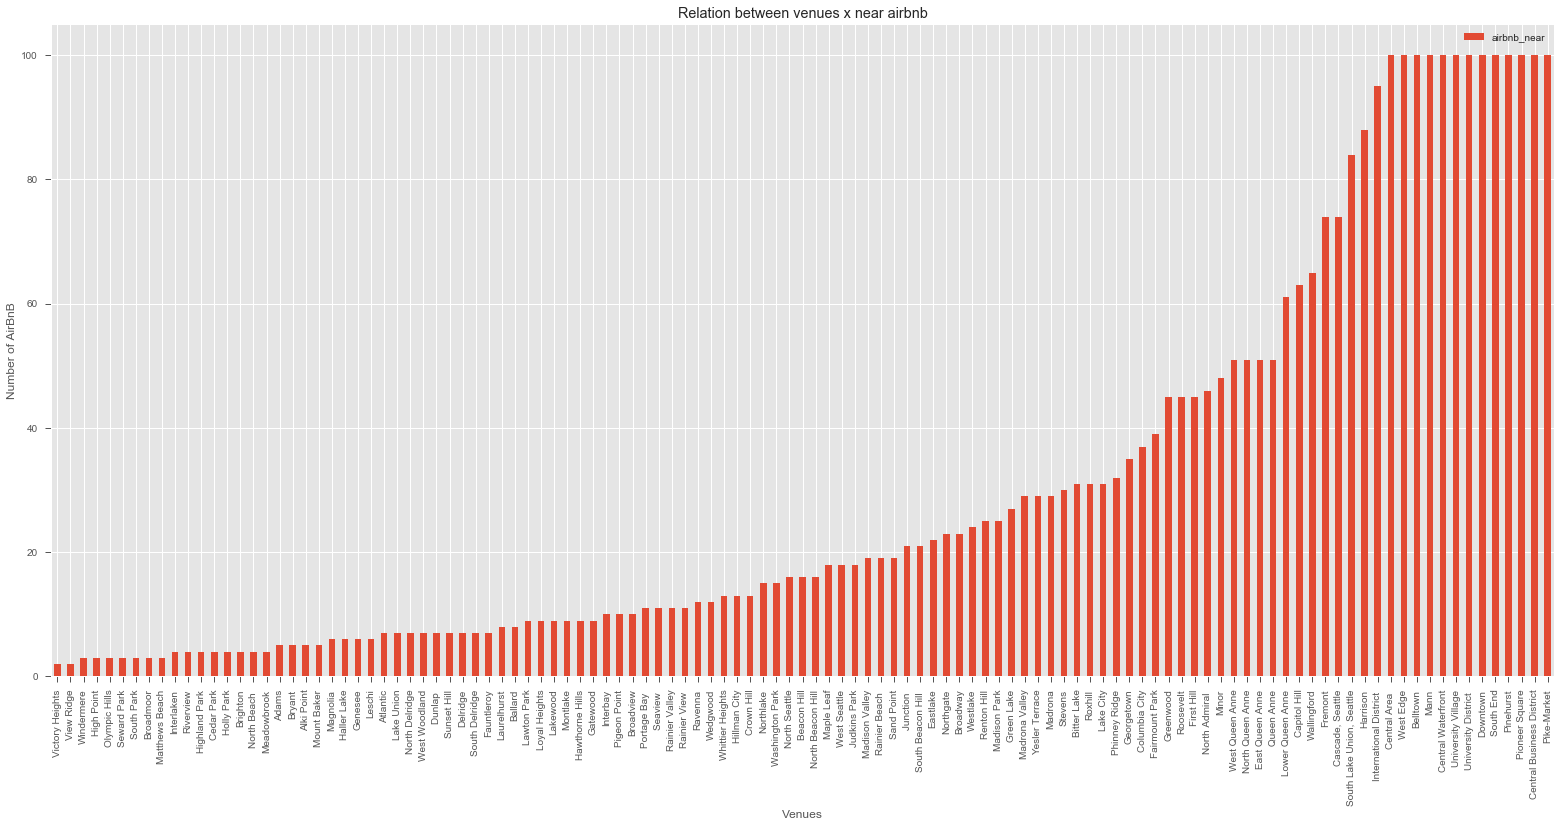

In [101]:
%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt

# grouping and counting each near airbnb
venues_airbnb_rel_plot = venues_airbnb_rel.groupby('Neighborhood')['airbnb_near'].count().reset_index()
venues_airbnb_rel_plot.set_index('Neighborhood', inplace=True)


print ('Matplotlib version: ', mpl.__version__)

mpl.style.use(['ggplot']) # optional: for ggplot-like style

# sort values before plot
venues_airbnb_rel_plot.sort_values(['airbnb_near']).plot(kind='bar', figsize=(24, 12))

plt.xlabel('Venues') # add to x-label to the plot
plt.ylabel('Number of AirBnB') # add y-label to the plot
plt.title('Relation between venues x near airbnb') # add title to the plot

plt.show()

**Box Plot allows you to quickly appreciate the average, minimum and maximum as other information about the relationship we have been observing.**

In [88]:
venues_airbnb_rel_plot.describe()

,airbnb_near
count,115.000000
mean,30.095652
std,31.926993
min,2.000000
25%,7.000000
50%,16.000000
75%,45.000000
max,100.000000


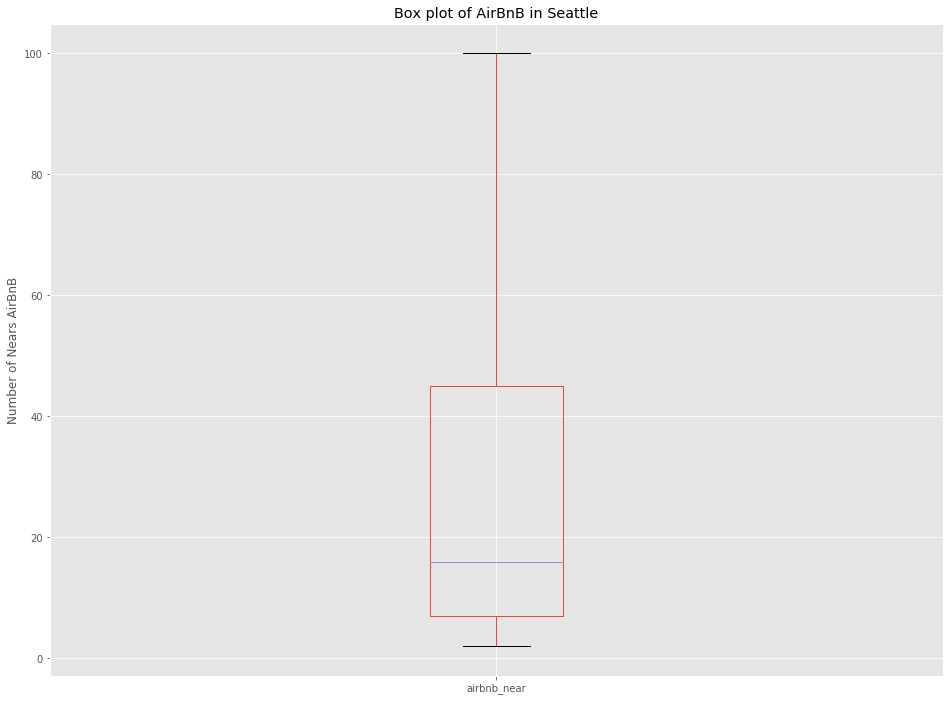

In [87]:
venues_airbnb_rel_plot.plot(kind='box', figsize=(16, 12))

plt.title('Box plot of AirBnB in Seattle')
plt.ylabel('Number of Nears AirBnB')

plt.show()

## <a id="4">4 - Showing on Map the trendings venues of Seattle and their connection with near AirBnB</a>

> Only enjoy it!

In [80]:
%%time
# first N venues due to my laptop capacity
m = venues_airbnb_rel.head(90)
# create map of Seattle using latitude and longitude values
map_seattle = folium.Map(location=[latitude, longitude], zoom_start=15)

points = plugins.MarkerCluster().add_to(map_seattle)

# add markers to map
for venue, lat, lng, neighborhood, distance, nearlat, nearlong, nearcount in zip(m['Venue'], m['Venue Latitude'], m['Venue Longitude'], m['Neighborhood'], m['distance_km'], m['near_airbnb_latitude'], m['near_airbnb_longitude'], m['airbnb_near']):
    label = '{}, {}, near airbnb: {}'.format(neighborhood, venue, nearcount)
    label = folium.Popup(label, parse_html=True, sticky=True)
    if isinstance(distance, str):
        t = distance.strip('][').split(',')
        nla = nearlat.strip('][').split(',')
        nlg = nearlong.strip('][').split(',')        
        for d, la, lg in zip(t, nla, nlg):
#             print ("{} : [{},{}] [{},{}]".format(d, lat, lng, la, lg))
            lbel = '{},{} distance: {}mt'.format(la, lg, round(float(d)*1000, 2))
            folium.CircleMarker(
                [la, lg],
                radius=2,
                popup=lbel,
                color='#c7103b',
                fill=True,
                fill_color='#c7103b',
                fill_opacity=0.6,
                parse_html=False).add_to(map_seattle)
            my_PolyLine=folium.PolyLine(locations=[[lat,lng], [la,lg]], weight=0.4,color='#fa46a3')
            map_seattle.add_child(my_PolyLine)
            
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='#853ab0',
        fill=True,
        fill_color='#853ab0',
        fill_opacity=0.7,
        parse_html=False).add_to(points)
    

    
map_seattle

CPU times: user 96 ms, sys: 12 ms, total: 108 ms
Wall time: 113 ms


## <a id="5">5 - Preparing data that to be clusterized</a>

In [41]:
seattle_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Adams,5,5,5,5,5,5
Alki Point,5,5,5,5,5,5
Atlantic,7,7,7,7,7,7
Ballard,8,8,8,8,8,8
Beacon Hill,16,16,16,16,16,16
Belltown,100,100,100,100,100,100
Bitter Lake,31,31,31,31,31,31
Brighton,4,4,4,4,4,4
Broadmoor,3,3,3,3,3,3


In [42]:
print('There are {} uniques categories.'.format(len(seattle_venues['Venue Category'].unique())))

There are 306 uniques categories.


In [45]:
%%time

# Analyze Each Neighborhood --------------
# one hot encoding
seattle_onehot = pd.get_dummies(seattle_venues[['Venue Category']], prefix="", prefix_sep="")
# print(list(seattle_onehot.columns))
seattle_onehot.drop('Neighborhood', axis=1, inplace=True)
# with method DataFrame.insert may resume some task.
seattle_onehot.insert(0, 'Neighborhood', venues_airbnb_rel['Neighborhood'])
seattle_onehot.insert(1, 'airbnb_near', venues_airbnb_rel['airbnb_near'])
seattle_onehot.head()


CPU times: user 32 ms, sys: 0 ns, total: 32 ms
Wall time: 30.8 ms


,Neighborhood,airbnb_near,ATM,Accessories Store,African Restaurant,American Restaurant,Amphitheater,Antique Shop,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,Auto Dealership,Auto Workshop,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Bath House,Beach,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Bowling Green,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Business Service,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,College Science Building,College Theater,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Costume Shop,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Fabric Shop,Fair,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flower Shop,Fondue Restaurant,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General College & University,General Travel,German Restaurant,Gift Shop,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Herbs & Spices Store,Historic Site,History Museum,Hobby Shop,Home Service,Hot Dog Joint,Hot Spring,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Insurance Office,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Knitting Store,Korean Restaurant,Lake,Latin American Restaurant,Lebanese Restaurant,Library,Lighthouse,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Marijuana Dispensary,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Movie Theater,Museum,Music Store,Music Venue,Nail Salon,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Repair Shop,Outdoor Sculpture,Outdoor Supply Store,Paper / Office Supplies Store,Park,Parking,Pawn Shop,Pedestrian Plaza,Peking Duck Restaurant,Performing Arts Venue,Peruvian Restaurant,Pet Service,Pet Store,Pharmacy,Pie Shop,Pier,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pool Hall,Post Office,Pub,Public Art,Radio Station,Ramen Restaurant,Record Shop,Recording Studio,Rental Service,Restaurant,Roof Deck,Rugby Pitch,Sake Bar,Salad Place,Salon / Barbershop,Salsa Club,Sandwich Place,Scenic Lookout,School,Science Museum,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Repair,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Ski Area,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Social Club,South American Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Stationery Store,Steakhouse,Storage Facility,Strip Club,Supermarket,Supplement Shop,Surf Spot,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park Ride / Attraction

In [93]:
seattle_onehot.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3842 entries, 0 to 3841
Columns: 336 entries, Neighborhood to Yoga Studio
dtypes: int64(1), object(1), uint8(334)
memory usage: 1.3+ MB


In [46]:
%%time
seattle_grouped = seattle_onehot.groupby('Neighborhood')[list(seattle_onehot.columns[2:])].mean().reset_index()
seattle_grouped_airbnb_count = seattle_onehot.groupby('Neighborhood')['airbnb_near'].sum().reset_index()

print(seattle_grouped.shape)
seattle_grouped.head(7)

(115, 306)
CPU times: user 52 ms, sys: 0 ns, total: 52 ms
Wall time: 47.9 ms


,Neighborhood,ATM,Accessories Store,African Restaurant,American Restaurant,Amphitheater,Antique Shop,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,Auto Dealership,Auto Workshop,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Bath House,Beach,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Bowling Green,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Business Service,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,College Science Building,College Theater,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Costume Shop,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Fabric Shop,Fair,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flower Shop,Fondue Restaurant,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General College & University,General Travel,German Restaurant,Gift Shop,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Herbs & Spices Store,Historic Site,History Museum,Hobby Shop,Home Service,Hot Dog Joint,Hot Spring,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Insurance Office,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Knitting Store,Korean Restaurant,Lake,Latin American Restaurant,Lebanese Restaurant,Library,Lighthouse,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Marijuana Dispensary,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Movie Theater,Museum,Music Store,Music Venue,Nail Salon,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Repair Shop,Outdoor Sculpture,Outdoor Supply Store,Paper / Office Supplies Store,Park,Parking,Pawn Shop,Pedestrian Plaza,Peking Duck Restaurant,Performing Arts Venue,Peruvian Restaurant,Pet Service,Pet Store,Pharmacy,Pie Shop,Pier,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pool Hall,Post Office,Pub,Public Art,Radio Station,Ramen Restaurant,Record Shop,Recording Studio,Rental Service,Restaurant,Roof Deck,Rugby Pitch,Sake Bar,Salad Place,Salon / Barbershop,Salsa Club,Sandwich Place,Scenic Lookout,School,Science Museum,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Repair,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Ski Area,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Social Club,South American Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Stationery Store,Steakhouse,Storage Facility,Strip Club,Supermarket,Supplement Shop,Surf Spot,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park Ride / Attraction,Thrift / Vi

In [ ]:
%%time
num_top_venues = 5

for hood in seattle_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = seattle_grouped[seattle_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

In [47]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]


In [48]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = seattle_grouped['Neighborhood']

for ind in np.arange(seattle_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(seattle_grouped.iloc[ind, :], num_top_venues)
print(neighborhoods_venues_sorted.shape)
neighborhoods_venues_sorted.head(10)

(115, 11)


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adams,Dog Run,Lake,Harbor / Marina,Pizza Place,Café,Zoo Exhibit,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant
1,Alki Point,Beach,Lighthouse,Baseball Field,Baseball Stadium,Zoo Exhibit,Fish & Chips Shop,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant
2,Atlantic,Sporting Goods Shop,Marijuana Dispensary,Food Truck,Grocery Store,Cheese Shop,Electronics Store,Thrift / Vintage Store,Flower Shop,Fish Market,Fish & Chips Shop
3,Ballard,Video Store,Restaurant,Baseball Field,Coffee Shop,Park,Jewelry Store,Bar,French Restaurant,Fondue Restaurant,Flower Shop
4,Beacon Hill,Café,Bakery,Grocery Store,Mexican Restaurant,Mediterranean Restaurant,Taco Place,Gas Station,Coffee Shop,Scenic Lookout,Sandwich Place
5,Belltown,Coffee Shop,Italian Restaurant,Breakfast Spot,Bar,Sushi Restaurant,Gym,Furniture / Home Store,New American Restaurant,Bakery,Lounge
6,Bitter Lake,Gym / Fitness Center,Grocery Store,Fast Food Restaurant,ATM,Discount Store,Boutique,Café,Chinese Restaurant,Seafood Restaurant,Clothing Store
7,Brighton,Food Truck,Convenience Store,Café,Greek Restaurant,Food & Drink Shop,Food,Fondue Restaurant,Food Court,Flower Shop,Fish Market
8,Broadmoor,Soccer Field,Golf Course,Playground,Zoo Exhibit,Fair,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field
9,Broadview,Food Truck,Furniture / Home Store,Antique Shop,Pizza Place,Convenience Store,Video Store,Thai Restaurant,Beer Bar,Sushi Restaurant,Zoo Exhibit


## <a id="5-1">5.1 Cluster Neighborhoods</a>

In [49]:
# set number of clusters
kclusters = 4

seattle_grouped_clustering = seattle_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(seattle_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_ 

array([3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 0, 0, 3, 3, 3, 0, 3, 3, 0, 3, 3, 3, 3, 2, 3,
       0, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 0, 3, 3, 0, 3, 3, 3, 0,
       3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0,
       3, 3, 3, 3, 1, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3,
       0, 3, 3, 0, 3], dtype=int32)

In [50]:
seattle_grouped_airbnb_count.head()

,Neighborhood,airbnb_near
0,Adams,18
1,Alki Point,36
2,Atlantic,2
3,Ballard,51
4,Beacon Hill,70


In [51]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
seattle_merged = neighborhoods

seattle_merged = seattle_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

# clear infinite labels after join         
seattle_merged = seattle_merged[np.isfinite(seattle_merged['Cluster Labels'])]
print("after... isfinite {}".format(seattle_merged.shape))
seattle_merged['Cluster Labels'].dropna(inplace=True)
print("drop NaN {}".format(seattle_merged.shape))
seattle_merged['Cluster Labels'] = seattle_merged['Cluster Labels'].astype(int)
seattle_merged = seattle_grouped_airbnb_count.join(seattle_merged.set_index('Neighborhood'), on='Neighborhood')

seattle_merged.head(3) # check the last columns!

after... isfinite (115, 15)
drop NaN (115, 15)


,Neighborhood,airbnb_near,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adams,18,Ballard,47.565300,-122.272014,3,Dog Run,Lake,Harbor / Marina,Pizza Place,Café,Zoo Exhibit,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant
1,Alki Point,36,West Seattle,47.576290,-122.420797,1,Beach,Lighthouse,Baseball Field,Baseball Stadium,Zoo Exhibit,Fish & Chips Shop,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant
2,Atlantic,2,Central Area,47.590493,-122.324313,3,Sporting Goods Shop,Marijuana Dispensary,Food Truck,Grocery Store,Cheese Shop,Electronics Store,Thrift / Vintage Store,Flower Shop,Fish Market,Fish & Chips Shop


In [55]:

seattle_zone = seattle_merged

def draw_map(zone, lat, long):
    # create map
    map_clusters = folium.Map(location=[lat, long], zoom_start=11)
    # set color scheme for the clusters
    x = np.arange(kclusters)
    ys = [i + x + (i*x)**2 for i in range(kclusters)]
    colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
    rainbow = [colors.rgb2hex(i) for i in colors_array]

    # add markers to the map
    markers_colors = []

    for lat, lon, poi, cluster, airbnb_near in zip(zone['Latitude'], zone['Longitude'], zone['Neighborhood'], zone['Cluster Labels'], zone['airbnb_near']):
        label = folium.Popup(str(poi) + ' Cluster ' + str(cluster) + ' AirBnB:' + str(airbnb_near), parse_html=True)    
        folium.CircleMarker(
            [lat, lon],
            radius=5,
            popup=label,
            color=rainbow[cluster],
            fill=True,
            fill_color=rainbow[cluster-1],
            fill_opacity=0.7).add_to(map_clusters)
       
    return map_clusters

draw_map(seattle_zone, latitude,longitude)


## <a id="5-2">5.2 Map Clustered</a>

**In the end we can observe the Clusterized data that in addition to belonging to a specific group we can segment the popularity of the proximity of a venue with an AirBnB.**

In [54]:
seattle_merged.loc[seattle_merged['Cluster Labels'] == 0, seattle_merged.columns[[0] + list(range(1, seattle_merged.shape[1]))]]


,Neighborhood,airbnb_near,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
14,Cedar Park,0,Lake City,47.725653,-122.285960,0,Vietnamese Restaurant,Supermarket,Fast Food Restaurant,Park,Food Court,Food & Drink Shop,Food,Fondue Restaurant,Flower Shop,Fish Market
29,Gatewood,24,West Seattle,47.536560,-122.385326,0,Park,IT Services,Pet Store,Gym,Gym / Fitness Center,Coffee Shop,Massage Studio,Fish Market,Fish & Chips Shop,Filipino Restaurant
30,Genesee,22,West Seattle,47.564821,-122.367905,0,Gym,Park,Golf Course,Skate Park,Soccer Field,Fast Food Restaurant,Fair,Falafel Restaurant,Farm,Farmers Market
34,Haller Lake,4,Northgate,47.720781,-122.330424,0,Food Truck,Playground,Coffee Shop,Lake,Dog Run,Park,Food,Fondue Restaurant,Food & Drink Shop,Flower Shop
37,High Point,3,Delridge,47.538451,-122.377387,0,Park,Field,Playground,Zoo Exhibit,Fish & Chips Shop,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant
44,Judkins Park,76,Atlantic,47.591470,-122.304069,0,Park,Museum,Rental Service,Scenic Lookout,Skate Park,Martial Arts Dojo,Dog Run,Trail,Gym / Fitness Center,Japanese Restaurant
51,Leschi,32,Central Area,47.600535,-122.291866,0,Park,Grocery Store,Pet Store,Playground,Pizza Place,Fast Food Restaurant,Fabric Shop,Fair,Falafel Restaurant,Farm
58,Magnolia,15,Central Seattle,47.648937,-122.393115,0,Park,Dog Run,Gym / Fitness Center,Korean Restaurant,Construction & Landscaping,Zoo Exhibit,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant
61,Matthews Beach,1,Lake City,47.696927,-122.272724,0,Park,Trail,Playground,Filipino Restaurant,Fair,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field
65,Mount Baker,4,Rainier Valley,47.578552,-122.289526,0,Park,Thai Restaurant,Pet Store,Pizza Place,Harbor / Marina,Fast Food Restaurant,Fabric Shop,Fair,Falafel Restaurant,Farm
